## Constraint Handling

### Inequality Constraints

**If somebody is interested in implementing or willing to make contribution(s) regarding constraint handling of inequality constraints please let us know.
The G problem is suite is already available to experiment with different algorithms. So far, mostly parameter-less constraint handling is used for our algorithms.**

### Equality Constraints

We got a couple of questions of how equality constraints should be handled in a genetic algorithm. In general, functions without any smoothness are challenging to handle for genetic algorithms. An equality constraint is basically an extreme case, where the constraint violation is 0 at exactly one point and otherwise 1. 

Let us consider the following constraint $g(x)$ where $x$ represents a variable:

$g(x): x = 5$

An equality constraint can be expressed by an inequality constraint:

$g(x): |x - 5| \leq 0$   

or

$g(x): (x-5)^2   \leq 0$

However, all of constraints above are very strict and make **most of the search space infeasible**. Without providing more information to the algorithm those constraint are very difficult to satisfy.

For this reason, the constraint can be smoothed by adding an epsilon to it and, therefore, having two inequality constraints:

$g'(x): 5 - \epsilon \leq x \leq 5 + \epsilon$

Also, it can be simply expressed in one inequality constraint by:

$g'(x): (x-5)^2  - \hat{\epsilon} \leq 0$

Depending on the $\epsilon$ the solutions will be more or less close to the desired value. However, the genetic algorithm does not know anything about the problem itself which makes it difficult to handle and focus the search in the infeasible space.

**Constraint Handling Through Repair**

A simple approach is to handle constraints through a repair function. This is only possible if the equation of the constraint is known. The repair makes sure every solution that is evaluated is in fact feasible. Let us consider the following example where 
the equality constraints need to consider more than one variable:

\begin{align} 
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\max \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\[1mm]
\text{s.t.} \;\; & g_1(x_1, x_3) : x_1 + x_3 = 2\\[2mm]
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2 \\
& -2 \leq x_3 \leq 2
\end{split}
\end{align}

We implement the problem using by squaring the term and using an $\epsilon$ as we have explained above. The source code for the problem looks as follows:

In [1]:
import numpy as np

from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([-2, -2, -2]),
                         xu=np.array([2, 2, 2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0] ** 2 + x[:, 1] ** 2
        f2 = (x[:, 0] - 1) ** 2 + x[:, 1] ** 2
        g1 = (x[:, 0] + x[:, 2] - 2) ** 2 - 1e-5

        out["F"] = np.column_stack([f1, f2])
        out["G"] = g1


As you might have noticed the problem has similar characteristics to problem in our getting started. 
Before a solution is evaluated a repair function is called. To make sure a solution is feasible, an approach would be to either set $x_3 = 2 - x_1$ or $x_1 = 2 - x_3$. Additionally, we need to consider that this repair might produce a variable to be out of bounds.

In [2]:
from pymoo.model.repair import Repair

class MyRepair(Repair):

    def _do(self, problem, pop, **kwargs):
        for k in range(len(pop)):
            x = pop[k].X
            if np.random.random() < 0.5:
                
                x[2] = 2 - x[0]
                if x[2] > 2:
                    val = x[2] - 2
                    x[0] += val
                    x[2] -= val
                    
            else:
                x[0] = 2 - x[2]
                if x[0] > 2:
                    val = x[0] - 2
                    x[2] += val
                    x[0] -= val
                
                
        return pop

Now the algorithm object needs to be initialized with the repair operator and then can be run to solve the problem:

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f    |  delta_max   | hist_delta_max
    1 |     100 |  0.00000E+00 |  0.00000E+00 |       5 |            - |            - |            - |            - |             -
    2 |     200 |  0.00000E+00 |  0.00000E+00 |      10 |  0.069443688 |  0.397759688 |  0.118613646 |  0.397759688 |  0.3977596883
    3 |     300 |  0.00000E+00 |  0.00000E+00 |      14 |  0.014530767 |  0.095980885 |  0.057639791 |  0.095980885 |  0.3977596883
    4 |     400 |  0.00000E+00 |  0.00000E+00 |      24 |  6.08912E-06 |  5.84301E-06 |  0.015418808 |  0.015418808 |  0.3977596883
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      29 |  0.00000E+00 |  4.44356E-16 |  0.018572002 |  0.018572002 |  0.3977596883
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      40 |  0.00000E+00 |  0.00000E+00 |  0.008808984 |  0.008808984 |  0.3977596883
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      66 |  0.00000E+00 |  0

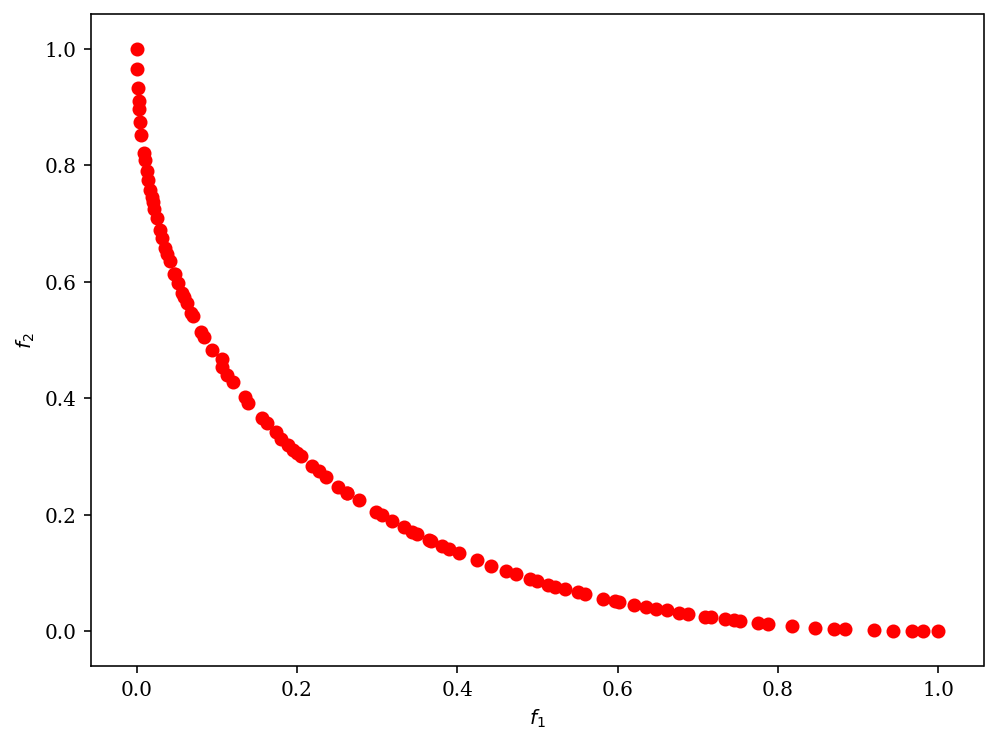

In [3]:
from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(pop_size=100, repair=MyRepair(), eliminate_duplicates=True)

from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

plot = Scatter()
plot.add(res.F, color="red")
plot.show()

In our case it is easy to verify if the constraint is violated or not:

In [4]:
print(res.X[:, 0] + res.X[:, 2])

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


If you would like to compare the solution without a repair you will see how searching only in the feasible space helps:

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f    |  delta_max   | hist_delta_max
    1 |     100 |  0.000035699 |  7.218880160 |       1 |            - |            - |            - |            - |             -
    2 |     200 |  0.000035699 |  0.937483763 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.000000E+00
    3 |     300 |  0.000035699 |  0.098161741 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.000000E+00
    4 |     400 |  0.00000E+00 |  0.024978835 |       1 |  3.360562566 |  3.360562566 |  4.74270E+30 |  4.74270E+30 |  4.742704E+30
    5 |     500 |  0.00000E+00 |  0.007024606 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  4.742704E+30
    6 |     600 |  0.00000E+00 |  0.001830226 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00 |  4.742704E+30
    7 |     700 |  0.00000E+00 |  0.000759620 |       2 |  1.000000000 |  1

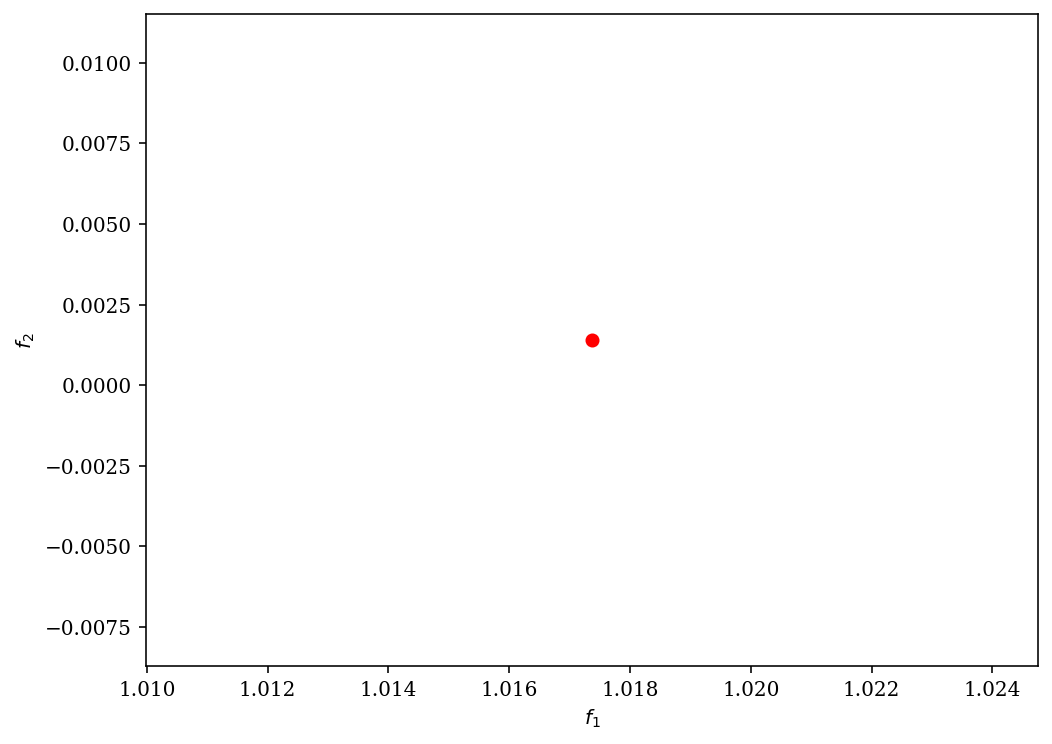

In [5]:
algorithm = NSGA2(pop_size=100, eliminate_duplicates=True)

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

plot = Scatter()
plot.add(res.F, color="red")
plot.show()



In [6]:
print(res.X[:, 0] + res.X[:, 2])

[2.00206869]


Here in fact the $\epsilon$ term is necessary to find any feasible solution at all.